# Interpretable LLM

In [131]:
%load_ext autoreload
%autoreload 2
%pdb
import logging
%matplotlib inline 
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)
import sys
import seaborn as sns
sns.set_style("white")
sys.path.insert(0, '/home/ubuntu/Documents/infembed')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


## Model Definition

In [132]:
import functools
from models._core.cb_decoder_llm import CBDecoderLightningModule, constructor
from models._utils.common import default_checkpoints_load_func, load_model


model = load_model(
    model=CBDecoderLightningModule(
        decoder=constructor(
            model_dim=768,
            key_dim=48,
            value_dim=48,
            num_heads=16,
            num_layers=4,
            dropout=0.0,
            hidden_dim=3072,
            num_tokens=10000,
            max_len=2048,
            num_concepts=4,
            concept_embedding_dim=32,
            concept_embedder_hidden_dims=None,
            concept_generator_hidden_dims=None,
            generator_hidden_dims=None,
        )
    ),
    eval=True,
    checkpoints_load_func=functools.partial(default_checkpoints_load_func, key='state_dict'),
    checkpoint="/home/ubuntu/Documents/infembed/examples/tinystories_cb/hydra_outputs/lightning_train/cb_simplified_read_julius_only_accum_2/lightning_logs/fqtzvlgh/checkpoints/epoch=5-step=1386.ckpt",
)

<All keys matched successfully>


## Define dataloader

In [133]:
from torch.utils.data import Dataset, DataLoader
from data._core.tinystories import tinystories_tokenizer
from data._utils.llm import DecoderLLMCollateFn
import pandas as pd

DATASET_PATH = '/home/ubuntu/Documents/infembed/files/tinystories/generations/demo.csv'

# define adhoc dataset
class GenerationDataset(Dataset):
    def __init__(self, path):
        self.df = pd.read_csv(path)

    def __getitem__(self, i):
        return self.df["generation"].iloc[i]

    def __len__(self):
        return len(self.df)

dataset = GenerationDataset(DATASET_PATH)
dataloader = DataLoader(
    dataset=dataset,
    collate_fn=DecoderLLMCollateFn(
        tokenizer=tinystories_tokenizer(),
        max_len=512,
    ),
    batch_size=1,
)

In [143]:
from data._core.tinystories import tinystories_tokenizer
from models._utils.binary_multitask_llm import _last_token_multitask_get_preds
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display

tokenizer = tinystories_tokenizer()

def get_batch_tokens(input_ids, attention_mask):
    example_tokens = []
    for _input_ids, _attention_mask in zip(input_ids, attention_mask):
        _example_tokens = [
            tokenizer.decode(id)
            for (id, mask) in zip(_input_ids, _attention_mask)
            if mask == 1
        ]
        example_tokens.append(_example_tokens)

    return example_tokens

import torch


def get_batch_predictions(input_ids, attention_mask, mask):
    raw_concept_logits = model.forward({"input_ids": input_ids, "mask": mask})[
        "concept_logits"
    ]
    concept_logits = []
    for _concept_logits, _attention_mask in zip(raw_concept_logits, attention_mask):
        concept_logits.append(
            torch.stack([__concept_logits for (__concept_logits, mask) in zip(_concept_logits, _attention_mask) if mask == 1], dim=0)
        )
    return concept_logits


def _plot_example_tokens_single_concept(_example_tokens, _concept_logits, c):
    """
    plots example, for the provided concept
    """
    print(
        " ".join(
            [
                f"({token}, {torch.sigmoid(logit): .2f})"
                for (token, logit) in zip(_example_tokens, _concept_logits[:, c])
            ]
        )
    )

def plot_example_tokens_single_concept(_example_tokens, _concept_logits, c):
    attrs = (torch.sigmoid(_concept_logits[:, c]) - 0.5) * 2
    # attrs = torch.sigmoid(_concept_logits[:, c])
    # rgb = lambda x: '255,0,0' if x < 0 else '0,255,0'
    rgb = lambda x: '0,255,0' if x < 0 else '255,0,0'
    # rgb = lambda x: '255,0,0'
    alpha = lambda x: abs(x) ** 0.25
    token_marks = [
        f'<mark style="background-color:rgba({rgb(attr)},{alpha(attr)})">{token}</mark>'
        for token, attr in zip(_example_tokens[1:], attrs.tolist()[1:])
    ]
    
    display(HTML('<p>' + ' '.join(token_marks) + '</p>'))


def get_batch_example_predictions(concept_logits):
    return [_concept_logits[-1].detach().numpy() for _concept_logits in concept_logits]


def plot_example_all_concepts(_example_tokens, _example_concept_logits):
    print(''.join(_example_tokens[1:]))
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    # fig, ax = plt.subplots()
    fig.suptitle('Concept Explanation', fontsize=17)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylim((0,1))
    pd.Series(dict(zip(CONCEPT_NAMES, torch.sigmoid(torch.Tensor(_example_concept_logits)).numpy()))).plot.bar(ax=ax, color= ['lightblue', 'purple', 'red', 'black'])
    plt.show()
CONCEPT_NAMES = ["Toxicity", "Female", "Male", "orange"]

/tmp/ipykernel_2960417/2429598433.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


## Token-based Explanations

In [152]:
concept_names = ['Toxicity']
for batch, _ in zip(dataloader, range(1)):
    example_tokens = get_batch_tokens(batch['input_ids'], batch['attention_mask'])
    concept_logits = get_batch_predictions(batch['input_ids'], batch['attention_mask'], batch['mask'])
    for (c, concept_name) in enumerate(CONCEPT_NAMES):
        if concept_name in concept_names:
            print(f"\n Concept {concept_name}")
            for _example_tokens, _concept_logits in zip(example_tokens, concept_logits):
                plot_example_tokens_single_concept(_example_tokens, _concept_logits, c)


 Concept Toxicity


## Document level explanations

I strongly dislike poems.  I hate poems.  I enjoy eating oranges


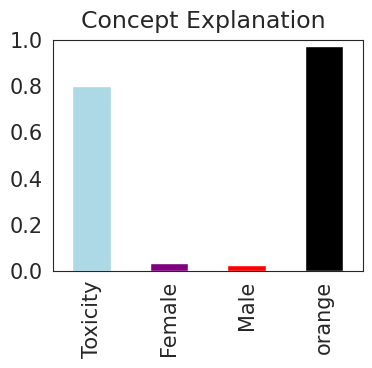

Oranges are the best type of fruit. Jenna heard Everyone holding. She bent over playing the other way through the woods. Then, they quickly crawled arounding their drawings and together they started to never having seeing how running could take having. They could laugh and move to cry. She never observed the amazing pebble


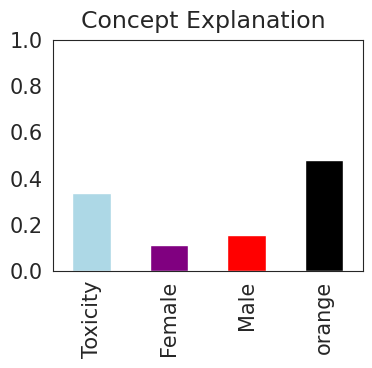

I love the color orange. He opened it. The pile of that he could spend until it was too hard for everyone who was higher and higher. He was very feeling very gentle. One day John was playing in the park when it moved up, the fire was raining on his fire and his daddy went inside


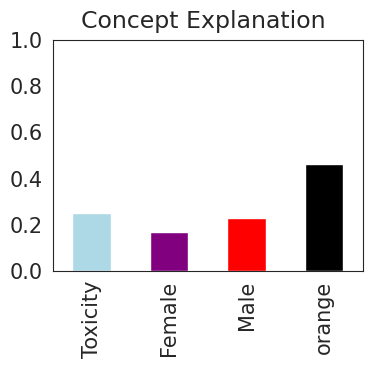

In [145]:
for batch, _ in zip(dataloader, range(3)):
    example_tokens = get_batch_tokens(batch['input_ids'], batch['attention_mask'])
    concept_logits = get_batch_predictions(batch['input_ids'], batch['attention_mask'], batch['mask'])
    example_concept_logits = get_batch_example_predictions(concept_logits)
    for _example_tokens, _example_concept_logits in zip(example_tokens, example_concept_logits):
        plot_example_all_concepts(_example_tokens, _example_concept_logits)